## Links

- [dbscSNV paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4267638/)
  - random forrest model: [randomForrest](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf) R package with default paramers:
    - `ntree=500` -> `n_estimators=500`
    - `mtry=floor(sqrt(ncol(x)))` -> already the default

## TODO

- [ ] deploy the model to kipoi: 
  - for the conservation models require the vcf to be annotated using VEP
    - extract the conservation scores then from there

In [1]:
import numpy as np
import m_kipoi
from copy import deepcopy
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
from m_kipoi.config import get_data_dir
from tqdm import tqdm
from m_kipoi.exp.splicing.data import get_dbscsnv_Xy, get_clinvar_ext_Xy

ddir = get_data_dir()

/opt/modules/i12g/anaconda/3-5.0.1/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Use these Kipoi models
models = ["MaxEntScan/3prime", "MaxEntScan/5prime", "HAL", "labranchor"]

### Data

#### ClinVar

In [4]:
X_clinvar, y_clinvar = get_clinvar_ext_Xy()

In [6]:
print(y_clinvar.mean())
print(len(y_clinvar))

0.6218811626511189
11663


In [8]:
X_clinvar['early_stop'] = X_clinvar.early_stop.astype(bool)
y_clinvar = y_clinvar[~X_clinvar['early_stop']]
X_clinvar = X_clinvar[~X_clinvar['early_stop']]

In [9]:
# permute

#### dbscSNV

In [10]:
X_dbscsnv, y_dbscsnv = get_dbscsnv_Xy()

## Features

In [11]:
kipoi_features = [x for m in models for x in X_dbscsnv.columns[X_dbscsnv.columns.str.startswith(m)]]

In [12]:
clinvar_kipoi_features = [x for m in models for x in X_clinvar.columns[X_clinvar.columns.str.startswith(m)]]

In [13]:
#X_clinvar['labranchor_alt'] = np.log(X_clinvar['labranchor_alt'] / (1-X_clinvar['labranchor_alt']))
#X_clinvar['labranchor_ref'] = np.log(X_clinvar['labranchor_ref'] / (1-X_clinvar['labranchor_ref']))

In [14]:
kipoi_features = ['MaxEntScan/3prime_alt',
                 'MaxEntScan/3prime_ref',
                 'MaxEntScan/3prime_isna',
                 'MaxEntScan/5prime_alt',
                 'MaxEntScan/5prime_ref',
                 'MaxEntScan/5prime_isna',
                 'HAL_ref',
                 'HAL_alt',
                 'HAL_isna',
                 'labranchor_logit_alt',
                 'labranchor_logit_ref',
                 'labranchor_isna']

In [15]:
kipoi_na_features = [x for x in kipoi_features if x.endswith("_isna")]

In [16]:
dbscsnv_model_features = ['PWM_ref', 'PWM_alt',
                          'MES_ref', 'MES_alt', 
                          'NNSplice_ref', 'NNSplice_alt', 
                          'HSF_ref', 'HSF_alt', 
                          'GeneSplicer_ref', 'GeneSplicer_alt', 
                          'GENSCAN_ref', 'GENSCAN_alt', 
                          'NetGene2_ref', 'NetGene2_alt', 
                          'SplicePredictor_ref', 'SplicePredictor_alt']

In [17]:
conservation_features = ['phyloP46way_placental', 'phyloP46way_primate', 'CADD_raw', 'CADD_phred']

In [18]:
dbscsnv_dbscsnv_feat = ['dbscSNV_rf_score', 'dbscSNV_rf_score_isna']

In [19]:
clinvar_cons_feat = ['CADD_raw', 'CADD_phred', 'phyloP46way_placental', 'phyloP46way_primate']
clinvar_dbscSNV_feat = ['dbscSNV_rf_score', 'dbscSNV_rf_score_isna']
spidex_feat = ['dpsi_max_tissue', 'dpsi_zscore', 'dpsi_max_tissue_isna', 'dpsi_zscore_isna']

In [20]:
dbscsnv_features = dbscsnv_model_features + conservation_features

## Modeling

In [21]:
# Scikit-learn imports
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn_pandas import DataFrameMapper

from m_kipoi.metrics import classification_metric, classification_metrics, BootstrapMetric, MetricsOrderedDict

/users/avsec/bin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
class ZeroImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return pd.DataFrame(X).fillna(0).copy()

In [23]:
def preproc(features):
    """Pre-processing pipeline
    """
    return DataFrameMapper([
            (features, [ZeroImputer(), 
                        sklearn.preprocessing.StandardScaler(),
                       ]),
        ])

In [24]:
# model = LogisticRegressionCV(penalty="l1", solver='liblinear', scoring="roc_auc", cv=3, n_jobs=1)
# LogReg is completely fine here as D < 20 < 1000 < N
model = LogisticRegression()

In [25]:
np.random.seed(42)

In [26]:
def evaluate(df, y, features, model, model_name):
        perm = np.random.permutation(len(df))  # permute rows
        ret = cross_validate(Pipeline([('preproc', preproc(features)), 
                                       ('model', model)]), 
                             df.iloc[perm], y[perm], scoring=['accuracy', 'roc_auc'], cv=10, n_jobs=10, return_train_score=True)
        means = pd.DataFrame(ret).describe().loc['mean']
        means.index = "mean_" + means.index
        sds = pd.DataFrame(ret).describe().loc['std']
        sds.index = "std_" + sds.index
        return pd.DataFrame([{**dict(means), **dict(sds), "model_name": model_name}])

In [27]:
def run_model_groups(df, y, model_groups,
                     model=LogisticRegressionCV(penalty="l1", solver='liblinear', scoring="roc_auc", cv=3, n_jobs=1)):
    res = []
    use_features = []
    for mg in tqdm(model_groups):
        use_features += [f for f in df.columns if f.startswith(mg)]
        if mg=='labranchor':
            mg = 'labranchor (KipoiSplice4)'
        res.append(evaluate(df, y, use_features, model, model_name=mg))
    return pd.concat(res)

In [32]:
res_dbscsnv = run_model_groups(X_dbscsnv, y_dbscsnv, models, model=model)

100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


In [33]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, kipoi_features + conservation_features, 
                                          model=model,
                                          model_name="KipoiSplice4 w/ cons."))

In [34]:
#res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, dbscsnv_model_features,
#                                          model=model,
#                                          model_name="dbscSNV w/o cons."))

In [35]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, dbscsnv_model_features + conservation_features,
                                          model=model,
                                          model_name="dbscSNV"))

In [36]:
#res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, dbscsnv_dbscsnv_feat,
#                                          model=model,
#                                          model_name="dbscSNV rf_score"))

In [37]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, spidex_feat,
                                          model=model,
                                          model_name="SPIDEX"))

In [38]:
res_dbscsnv = res_dbscsnv.append(evaluate(X_dbscsnv, y_dbscsnv, spidex_feat + clinvar_cons_feat,
                                          model=model,
                                          model_name="SPIDEX w/ cons."))

In [39]:
res_clinvar = run_model_groups(X_clinvar, y_clinvar, models, model=model)

100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


In [40]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, clinvar_kipoi_features + clinvar_cons_feat, 
                                          model=model,
                                          model_name="KipoiSplice4 w/ cons."))

In [41]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, dbscsnv_dbscsnv_feat,
                                          model=model,
                                          model_name="dbscSNV"))

In [42]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, spidex_feat,
                                          model=model,
                                          model_name="SPIDEX"))

In [43]:
res_clinvar = res_clinvar.append(evaluate(X_clinvar, y_clinvar, spidex_feat + clinvar_cons_feat,
                                          model=model,
                                          model_name="SPIDEX w/ cons."))

In [86]:
y_clinvar.mean()

0.5888940737284181

In [89]:
np.sum(y_clinvar==0)

4405

In [88]:
y_clinvar.size

10715

In [44]:
X_clinvar[clinvar_kipoi_features].describe()

,MaxEntScan/3prime_alt,MaxEntScan/3prime_ref,MaxEntScan/3prime_isna,MaxEntScan/5prime_alt,MaxEntScan/5prime_ref,MaxEntScan/5prime_isna,HAL_alt,HAL_ref,HAL_isna,labranchor_alt,labranchor_ref,labranchor_isna
count,4475.000000,4475.000000,10715.000000,3562.000000,3562.000000,10715.000000,6588.000000,6588.000000,10715.000000,4381.000000,4381.000000,10715.000000
mean,5.043700,8.380579,0.582361,2.089179,8.195538,0.667569,9.951030,13.727115,0.385161,0.318928,0.322029,0.591134
std,4.976669,2.983431,0.493193,4.085698,2.675553,0.471107,5.499314,3.177463,0.486656,0.259886,0.269793,0.491647
min,-27.178087,-27.208165,0.000000,-31.974668,-38.362911,0.000000,-4.158578,-4.469630,0.000000,0.000032,0.000031,0.000000
25%,1.075200,6.978045,0.000000,-0.199414,7.303878,0.000000,4.823227,11.899383,0.000000,0.103977,0.094611,0.000000
50%,6.109886,8.684237,1.000000,1.450201,8.680067,1.000000,11.023940,13.779176,0.000000,0.246483,0.249476,1.000000
75%,9.133985,10.222266,1.000000,4.105201,9.787718,1.000000,14.321706,15.767149,1.000000,0.489607,0.504195,1.000000
max,14.729229,14.926790,1.000000,11.806539,11.806539,1.000000,26.847177,26.847177,1.000000,0.975016,0.978082,1.000000


### Plot

In [45]:
import matplotlib.pyplot as plt

In [46]:
cm = plt.get_cmap('tab10')

In [51]:
list(res_dbscsnv.model_name[:5])

['MaxEntScan/3prime',
 'MaxEntScan/5prime',
 'HAL',
 'labranchor (KipoiSplice4)',
 'KipoiSplice4 w/ cons.']

In [57]:
list(res_dbscsnv.model_name[5:])

['dbscSNV', 'SPIDEX', 'SPIDEX w/ cons.']

In [54]:
kipoi_model_names = [
    'MaxEntScan/3prime',
     '+MaxEntScan/5prime',
     '+HAL',
     '+labranchor',
     '+conservation (KipoiSplice4)']

In [78]:
res_clinvar = res_clinvar.iloc[:-2]

In [82]:
other_model_names = ['dbscSNV', 'SPIDEX', 'SPIDEX+conservation']

In [80]:
cv_other_model_names = list(res_clinvar.model_name[5:])

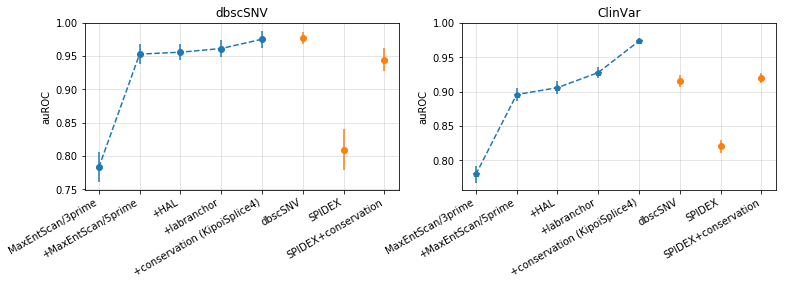

In [85]:
fig=plt.figure(figsize=(12, 4))
fig.subplots_adjust(bottom=0.3, left=0.1)
plt.subplot(121)
col1 = cm.colors[0]
col2 = cm.colors[1]
tilt = 30
plt.errorbar(kipoi_model_names, res_dbscsnv.mean_test_roc_auc[:5], yerr=res_dbscsnv.std_test_roc_auc[:5], fmt='o--', color=col1)
#plt.errorbar(res_dbscsnv.model_name[4:5], res_dbscsnv.mean_test_roc_auc[4:5], yerr=res_dbscsnv.std_test_roc_auc[4:5], fmt='o', color=col1)
plt.errorbar(other_model_names, res_dbscsnv.mean_test_roc_auc[5:], yerr=res_dbscsnv.std_test_roc_auc[5:], fmt='o', color=col2)
plt.ylabel("auROC")
#plt.errorbar(["asd"], [.9], yerr=[.1], fmt='o--')
plt.title("dbscSNV")
plt.ylim((None, 1))
plt.grid(alpha=0.4)
plt.xticks(rotation=tilt, horizontalalignment="right");
plt.subplot(122)
plt.errorbar(kipoi_model_names, res_clinvar.mean_test_roc_auc[:5], yerr=res_clinvar.std_test_roc_auc[:5], fmt='p--', color=col1)
#plt.errorbar(res_clinvar.model_name[4:5], res_clinvar.mean_test_roc_auc[4:5], yerr=res_clinvar.std_test_roc_auc[4:5], fmt='o', color=col1)
plt.errorbar(other_model_names, res_clinvar.mean_test_roc_auc[5:], yerr=res_clinvar.std_test_roc_auc[5:], fmt='o', color=col2)
plt.title("ClinVar")
plt.grid(alpha=0.4)
plt.ylim((None, 1))
plt.ylabel("auROC")
plt.xticks(rotation=tilt, horizontalalignment="right");
#plt.tight_layout(h_pad=0);
plt.savefig('plots/fig5c_clinvar_20180429.png', dpi=600)
plt.savefig('plots/fig5c_clinvar_20180429.pdf', dpi=600)
plt.close(fig)    # close the figure
fig

In [165]:
isna_clinvar = X_clinvar.filter(like="_isna", axis=1)

In [166]:
isna_clinvar['KipoiSplice4_isna'] = isna_clinvar[pd.Series(models)+"_isna"].min(axis=1)
isna_clinvar = isna_clinvar.mean().sort_index().reset_index().rename(columns={"index": "Method", 0: "NA_frac"})
isna_clinvar['Dataset'] = "ClinVar"
isna_clinvar['Method'] = isna_clinvar['Method'].str.replace("_isna", "")

/users/avsec/bin/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [167]:
isna_dbscsnv = X_dbscsnv.iloc[:,~X_dbscsnv.columns.str.contains("rbp_eclip")].filter(like="_isna", axis=1)
isna_dbscsnv['KipoiSplice4_isna'] = isna_dbscsnv[pd.Series(models)+"_isna"].min(axis=1)
isna_dbscsnv = isna_dbscsnv.mean().sort_index().reset_index().rename(columns={"index": "Method", 0: "NA_frac"})
isna_dbscsnv['Dataset'] = "dbscSNV"
isna_dbscsnv['Method'] = isna_dbscsnv['Method'].str.replace("_isna", "")

In [168]:
df_isna = pd.concat([isna_clinvar, isna_dbscsnv])

In [169]:
df_isna = df_isna[~df_isna.Method.str.contains("ada_score")]
df_isna = df_isna[~df_isna.Method.str.contains("max_tissue")]

In [170]:
df_isna['Method'] = df_isna.Method.replace({"dbscSNV_rf_score": "dbscSNV", 'dpsi_zscore': 'SPIDEX'})

In [171]:
methods = df_isna.Method.unique()[::-1].tolist()
datasets = df_isna.Dataset.unique()[::-1].tolist()

In [172]:
methods =['MaxEntScan/3prime',
          'MaxEntScan/5prime',
          'HAL',
          'labranchor',
          'Kipoi4',
          'dbscSNV',
          'SPIDEX'][::-1]

In [173]:
import plotnine

In [178]:
df_isna

,Method,NA_frac,Dataset
0,HAL,0.385161,ClinVar
1,KipoiSplice4,0.000000,ClinVar
2,MaxEntScan/3prime,0.582361,ClinVar
3,MaxEntScan/5prime,0.667569,ClinVar
5,dbscSNV,0.363976,ClinVar
7,SPIDEX,0.063462,ClinVar
8,labranchor,0.591134,ClinVar
0,HAL,0.367354,dbscSNV
1,KipoiSplice4,0.000338,dbscSNV
2,MaxEntScan/3prime,0.567421,dbscSNV


In [204]:
methods

In [205]:
df_isna['Method'] = pd.Categorical(df_isna.Method, methods)

In [206]:
df_isna['Dataset'] = pd.Categorical(df_isna.Dataset, datasets)

In [207]:
df_isna = df_isna.reset_index()

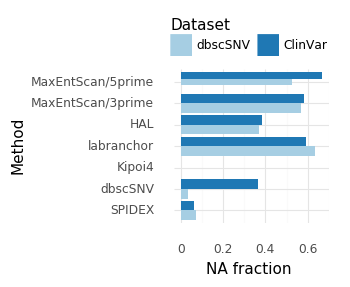

<ggplot: (-9223363298649943243)>

In [213]:
plotnine.options.figure_size = (2,2)
gplt = ggplot(aes(x="Method", y="NA_frac", fill="Dataset"), df_isna) + \
    geom_bar(stat='identity', position='dodge') + \
    ylab("NA fraction") + \
    theme_minimal() + \
    theme(legend_box_margin=0,
          legend_direction='horizontal', 
          legend_position='top') + \
    coord_flip()  + \
        scale_fill_brewer("qual", 3)
gplt

In [214]:
gplt.save("plots/fig5b_clinvar_20180429.pdf", dpi=600)
gplt.save("plots/fig5b_clinvar_20180429.png", dpi=600)

/users/avsec/bin/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 2 x 2 in image.
  from_inches(height, units), units))
/users/avsec/bin/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: fig5b_clinvar_20180429.pdf
  warn('Filename: {}'.format(filename))
/users/avsec/bin/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: fig5b_clinvar_20180429.png
  warn('Filename: {}'.format(filename))
